# Predicting mode choice behavior based on person characteristics

Members & Student numbers: Willemijn ten Voorden (6101275), Frederiek Backers (4704452), Annerieke Ohm (4852990), Nikolaos Tsironis (6008712)

# Research Objective
This research proposal is made for the TIL Programming TIL6022 course project. We focus on an application project on mobility trends in The Netherlands using open-source data, making this a societal project. We were inspired by the current discussions on introducing rush hour tax for train tickets in the Netherlands [1]. Looking at the discussion, we were wondering if there are certain personal characteristics that can be related to mode choice behavior. This resulted in the following research question:

**How do personal characteristics influence mode choice behaviour of adult travellers in The Netherlands during the years 2018-2022?**

To answer this research question we will do some data processing, quantitative analysis and visualize our results. To be able to answer our research question, we present some subquestions:

1. *What is the probability for a person to choose a certain transport mode based on one personal characteristic?*
2. *From the previous subquestion, which personal characteristics jump out and could be researched further?*
3. *Is there a significant difference over the years in mode choice?*
4. *Can the groups obtained through K-means clustering based on personal characteristics effectively reflect distinct transportation mode preferences?*


For every subquestion we do the following quantitative analysis and visualisations:
1. Use probability theory, make plots and interpret results.
2. Make (interactive) plots for various personal charactertics and elaborate on the results.
3. Comparison between the years using both absolute numbers as well as relative numbers, showing the general change in transport movements as well as the difference in mode distribution.
4. We use K-means clustering to cluster the data into k clusters. The number of clusters k is determined by using the Elbow method and checking the BIC, Silhouette and Davies scores. Then we cluster the data and check the correlation between the clusters and the mode choices, and check which personal characteristics belong to which cluster.

The data is obtained from CBS (Central Bureau for Statistics Netherlands) that includes mode choice and personal characteristics of individuals. The data will be explained more thoroughly in the data section.

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Willemijn**: Stating research question and obtaining data, background research, analysis subquestion 2 (income groups & background), conclusion, parts lay-out.

**Nick**: Analysis subquestion 2 (age groups & transport vs. car ownership vs. neither).

**Annerieke**: Stating research question and obtaining data, data processing, analysis subquestion 1 and 3, limitations and recommendations.

**Frederiek**: Stating research question and obtaining data, data used, data processing, analysis subquestion 4, finalising conclusion, general lay-out report.

# Data Used

For this research project we use one dataset obtained from CBS that includes mode choice and personal characteristics of individuals:

*StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl)* [2]

The dataset contains information about the travel behavior of the Dutch population aged 6 and older in private households, excluding residents of institutions and homes. The data includes the number of trips, distance traveled and average travel duration per person, per day and per year. It covers regular movements within the Netherlands, including domestic vacation mobility. Series movements are not considered regular movements. The data from years 2018-2022 is used.

Travel behavior is broken down into personal characteristics, modes of transportation, population, gender and regions. To slim the dataset this study only focuses on the average number of trips for every mode per day, for every person characteristic. We use only certain personal characteristics such as income, migration background, education level, participation and availability of a student PT card and drivers license, next to gender and age. Some other scale limitations are:
- Geographical boundary: the Netherlands
- Travel modes: car, public transport, active modes and other modes
- Time scale: 2018-2022
- Ages: 18 years and older



# Data Pipeline
This section includes pipeline that the data goes through to obtain the dataset that is used throughout the rest of the report. It includes the importing of needed packages and data, data processing and it ends with an example of the data.

## Import packages

In [59]:
import os
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import display

# Packages for machine learning method k-means clustering
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

## Import data

In [60]:
file_path = os.getcwd() + '\Data.csv'

# Read data: remove first 6 rows and last row that do not contain data
data = pd.read_csv(file_path, delimiter = ';', skiprows = 6, skipfooter = 1, engine = 'python')

## Data processing

In [61]:
# Make person characteristics index
data.set_index('Vervoerwijzen', inplace = True)

# Remove rows with missing information
data_updated = data.drop(labels = ["Persoonskenmerken", "Totaal personen", "Leeftijd:6 tot 12 jaar", "Leeftijd: 12 tot 18 jaar",
                                   "Participatie: werkloos", "Participatie:  arbeidsongeschikt", 
                                   "Geen rijbewijs; jonger dan 17 jaar", "OV-Studentenkaart: weekendabonnement"])

# Replace dots in dataset with 0
data_updated = data_updated.replace('.', 0)

# Only keep columns with average number of movements per day per person
columns_to_keep = [col for col in data_updated.columns if 
                   data_updated.loc["Onderwerp", col] == "Gemiddeld per persoon per dag |Verplaatsingen "]
data_updated = data_updated[columns_to_keep]

# Remove the "onderwerp" row, since this is now the same for all columns
data_updated = data_updated.drop("Onderwerp")

# The data is formatted as strings, we convert these to floats and make NaN's equal to 0 for all three dataframes
def preprocess_dataframe(df):
    # Convert strings to floats and replace NaN values with 0
    df = df.apply(lambda col: col.str.replace(',', '.').astype(float).fillna(0))
    return df

data_updated = preprocess_dataframe(data_updated)

# Merge the rows "Leeftijd: 65 tot 75 jaar" en "75jaar of ouder" into one row
data_updated = (data_updated.reset_index()
                .replace({"Vervoerwijzen": {"Leeftijd: 75 jaar of ouder" : "Leeftijd: 65 tot 75 jaar"}})
                .groupby("Vervoerwijzen", sort=False).sum()
)
data_updated = data_updated.rename({"Leeftijd: 65 tot 75 jaar" : "Leeftijd: 65 jaar of ouder"})

# Split dataframe into 5 separate datframes: one for each year and remove row "perioden"
columns_2018 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2018]
columns_2019 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2019]
columns_2020 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2020]
columns_2021 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2021]
columns_2022 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2022]
transport_2018 = data_updated[columns_2018].drop("Perioden")
transport_2019 = data_updated[columns_2019].drop("Perioden")
transport_2020 = data_updated[columns_2020].drop("Perioden")
transport_2021 = data_updated[columns_2021].drop("Perioden")
transport_2022 = data_updated[columns_2022].drop("Perioden")

# Merge car driver and passenger into car, cycle and walk into active modes and trainand bus/tram/metro into public transport
def merge_transport_categories(df):
    # The different years have a number behind the column names. Remove these numbers.
    column_names = ["Total", "Personenauto (bestuurder)", "Personenauto  (passagier)", 
                    "Trein", "Bus/tram/metro", "Fiets", "Lopen", "Overige vervoerwijze"]
    df.columns = column_names
    # Merge desired columns
    df["Passengercar"] = df["Personenauto (bestuurder)"] + df["Personenauto  (passagier)"]
    df["Public Transport"] = df["Trein"] + df["Bus/tram/metro"]
    df["Active modes"] = df["Fiets"] + df["Lopen"]
    df = df.drop(columns = ["Personenauto (bestuurder)", "Personenauto  (passagier)", "Trein", 
                            "Bus/tram/metro", "Fiets", "Lopen"])
    # Move "Overige vervoerswijze" to the end of the dataframe
    Other = df.pop("Overige vervoerwijze")
    df["Other modes"] = Other
    # Translate all index names to English
    index_names = ["Age: 18 to 25 years", "Age: 25 to 35 years", "Age: 35 to 50 years", "Age: 50 to 65 years", 
                   "Age: 65 years or older", "Migrationbackground: The Netherlands", "Migrationbackground: Western", 
                   "Migrationbackground: Non-western", "Standardised income: 1st 20% group", 
                   "Standardised income: 2nd 20% group","Standardised income: 3rd 20% group", 
                   "Standardised income: 4th 20% group", "Standardised income: 5th 20% group", 
                   "PT-studentcard: Weekday subscription", "PT-studentcard: None","Education level: Low", 
                   "Education level: middle", "Education level: High", "Participation: Working 12 to 30 h/w",
                   "Participation: Working 30+ h/w", "Participation: student", "Participation: retired",
                   "Participation: Other", "Drivers licence; owns own car", "Drivers license; car in household",
                   "Drivers license; no car", "No drivers license"]
    df.index = index_names

    return df

transport_2018 = merge_transport_categories(transport_2018)
transport_2019 = merge_transport_categories(transport_2019)
transport_2020 = merge_transport_categories(transport_2020)
transport_2021 = merge_transport_categories(transport_2021)
transport_2022 = merge_transport_categories(transport_2022)

In [62]:
# Example of what a dataset now looks like. Layout the same for all years, only numbers might differ.
transport_2018

Total  Passengercar  Public Transport  \
Age: 18 to 25 years                    2.74          1.05              0.44   
Age: 25 to 35 years                    2.99          1.52              0.24   
Age: 35 to 50 years                    3.20          1.71              0.13   
Age: 50 to 65 years                    2.80          1.45              0.11   
Age: 65 years or older                 4.05          1.85              0.12   
Migrationbackground: The Netherlands   2.90          1.38              0.12   
Migrationbackground: Western           2.57          1.09              0.20   
Migrationbackground: Non-western       2.22          0.82              0.31   
Standardised income: 1st 20% group     2.45          0.79              0.22   
Standardised income: 2nd 20% group     2.46          1.07              0.14   
Standardised income: 3rd 20% group     2.88          1.34              0.14   
Standardised income: 4th 20% group     3.01          1.49              0.14   
Standardised income: 5th 20% group     3.00          1.57              0.15   
PT-studentcard: Weekday subscription   2.76          0.80              0.80   
PT-studentcard: None                   2.78          1.30              0.12   
Education level: Low                   2.24          0.94              0.11   
Education level: middle                2.91          1.49              0.18   
Education level: High                  3.10          1.56              0.20   
Participation: Working 12 to 30 h/w    3.35          1.69              0.14   
Participation: Working 30+ h/w         2.98          1.68              0.17   
Participation: student                 2.85          0.76              0.26   
Participation: retired                 2.14          1.00              0.06   
Participation: Other                   2.52          1.12              0.09   
Drivers licence; owns own car          2.90          1.79              0.06   
Drivers license; car in household      2.99          1.59              0.14   
Drivers license; no car                2.84          0.57              0.40   
No drivers license                     2.13          0.43              0.32   

                                      Active modes  Other modes  
Age: 18 to 25 years                           1.12         0.13  
Age: 25 to 35 years                           1.10         0.12  
Age: 35 to 50 years                           1.22         0.14  
Age: 50 to 65 years                           1.12         0.12  
Age: 65 years or older                        1.94         0.13  
Migrationbackground: The Netherlands          1.28         0.12  
Migrationbackground: Western                  1.21         0.08  
Migrationbackground: Non-western              1.03         0.07  
Standardised income: 1st 20% group            1.33         0.10  
Standardised income: 2nd 20% group            1.16         0.10  
Standardised income: 3rd 20% group            1.27         0.12  
Standardised income: 4th 20% group            1.27         0.12  
Standardised income: 5th 20% group            1.19         0.10  
PT-studentcard: Weekday subscription          1.07         0.09  
PT-studentcard: None                          1.24         0.11  
Education level: Low                          1.04         0.14  
Education level: middle                       1.10         0.15  
Education level: High                         1.29         0.06  
Participation: Working 12 to 30 h/w           1.44         0.07  
Participation: Working 30+ h/w                0.98         0.16  
Participation: student                        1.76         0.08  
Participation: retired                        1.02         0.05  
Participation: Other                          1.21         0.10  
Drivers licence; owns own car                 0.93         0.11  
Drivers license; car in household             1.15         0.12  
Drivers license; no car                       1.67         0.21  
No drivers license                         

# Data analysis

This section includes all the analysis that is done for the several subquestions described in the section on the Research Question. The analysis is divided up into the four subquestions, where all the results are discussed and a conclusion is available at the end of the section.

### *Subquestion 1: What is the probability for a person to choose a certain transport mode based on one personal characteristic?*
To answer this question, first a general understanding of the data is required. To do this the data is normalised per personal characteristic by dividing the number of movements per mode by the total number of movements for that row. This way, the numbers in the dataset become independent of how much a certain group travels and instead show the distribution of the group's travels over the different modes. This is then visualised using stacked barplots, allowing for comparison between the different groups. This is done for each year separately, allowing for both comaparison within one year as well as comparison between the different years.

In [63]:
# Normalise dataframe rows
def normal_rows(df):
    normal_df = df.drop(columns = ["Total"])
    normal_df = normal_df.div(normal_df.sum(axis = 1), axis = 0)
    return normal_df

normal_2018 = normal_rows(transport_2018)
normal_2019 = normal_rows(transport_2019)
normal_2020 = normal_rows(transport_2020)
normal_2021 = normal_rows(transport_2021)
normal_2022 = normal_rows(transport_2022)

normal_2018

Passengercar  Public Transport  \
Age: 18 to 25 years                       0.383212          0.160584   
Age: 25 to 35 years                       0.510067          0.080537   
Age: 35 to 50 years                       0.534375          0.040625   
Age: 50 to 65 years                       0.517857          0.039286   
Age: 65 years or older                    0.457921          0.029703   
Migrationbackground: The Netherlands      0.475862          0.041379   
Migrationbackground: Western              0.422481          0.077519   
Migrationbackground: Non-western          0.367713          0.139013   
Standardised income: 1st 20% group        0.323770          0.090164   
Standardised income: 2nd 20% group        0.433198          0.056680   
Standardised income: 3rd 20% group        0.466899          0.048780   
Standardised income: 4th 20% group        0.493377          0.046358   
Standardised income: 5th 20% group        0.521595          0.049834   
PT-studentcard: Weekday subscription      0.289855          0.289855   
PT-studentcard: None                      0.469314          0.043321   
Education level: Low                      0.421525          0.049327   
Education level: middle                   0.510274          0.061644   
Education level: High                     0.501608          0.064309   
Participation: Working 12 to 30 h/w       0.505988          0.041916   
Participation: Working 30+ h/w            0.561873          0.056856   
Participation: student                    0.265734          0.090909   
Participation: retired                    0.469484          0.028169   
Participation: Other                      0.444444          0.035714   
Drivers licence; owns own car             0.619377          0.020761   
Drivers license; car in household         0.530000          0.046667   
Drivers license; no car                   0.200000          0.140351   
No drivers license                        0.202830          0.150943   

                                      Active modes  Other modes  
Age: 18 to 25 years                       0.408759     0.047445  
Age: 25 to 35 years                       0.369128     0.040268  
Age: 35 to 50 years                       0.381250     0.043750  
Age: 50 to 65 years                       0.400000     0.042857  
Age: 65 years or older                    0.480198     0.032178  
Migrationbackground: The Netherlands      0.441379     0.041379  
Migrationbackground: Western              0.468992     0.031008  
Migrationbackground: Non-western          0.461883     0.031390  
Standardised income: 1st 20% group        0.545082     0.040984  
Standardised income: 2nd 20% group        0.469636     0.040486  
Standardised income: 3rd 20% group        0.442509     0.041812  
Standardised income: 4th 20% group        0.420530     0.039735  
Standardised income: 5th 20% group        0.395349     0.033223  
PT-studentcard: Weekday subscription      0.387681     0.032609  
PT-studentcard: None                      0.447653     0.039711  
Education level: Low                      0.466368     0.062780  
Education level: middle                   0.376712     0.051370  
Education level: High                     0.414791     0.019293  
Participation: Working 12 to 30 h/w       0.431138     0.020958  
Participation: Working 30+ h/w            0.327759     0.053512  
Participation: student                    0.615385     0.027972  
Participation: retired                    0.478873     0.023474  
Participation: Other                      0.480159     0.039683  
Drivers licence; owns own car             0.321799     0.038062  
Drivers license; car in household         0.383333     0.040000  
Drivers license; no car                   0.585965     0.073684  
No drivers license                        0.603774     0.042453

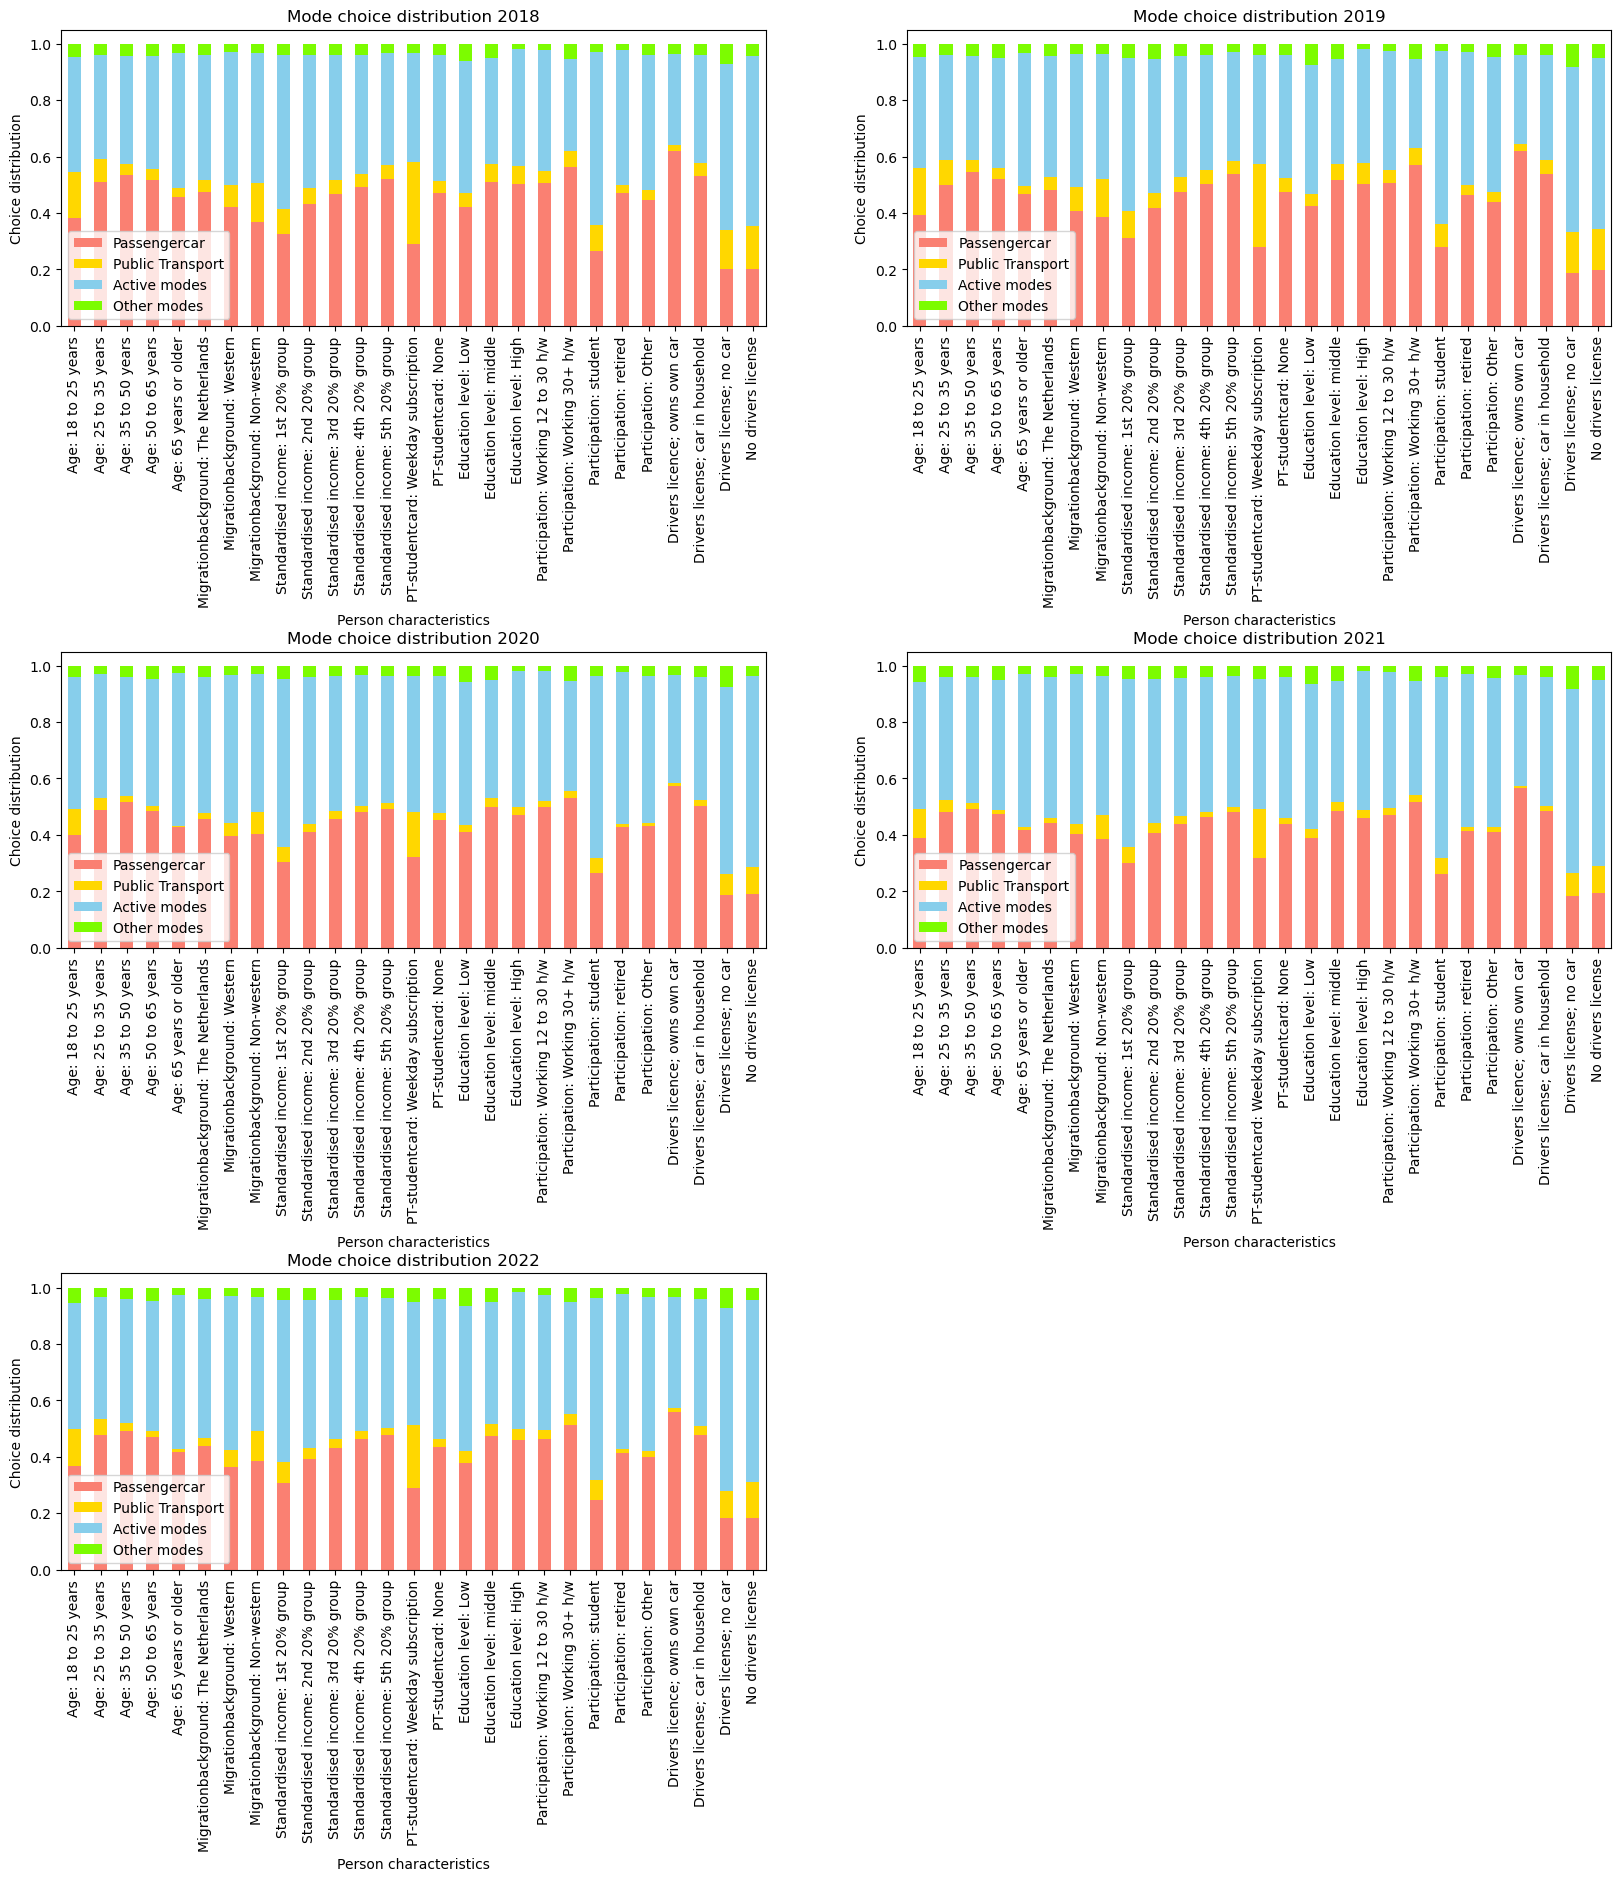

In [64]:
# Filtered DataFrame for each year
dfs = [normal_2018, normal_2019, normal_2020, normal_2021, normal_2022]

# Changing layout of plots for better readability 
fig, axes = plt.subplots(3, 2, figsize=(20, 20)) # Two rows to show the 5 plots to prevent cluttering
fig.subplots_adjust(hspace=1.1)  
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(dfs):
        df = dfs[i]
        df.plot(kind='bar', stacked=True, color = ["salmon", "gold", "skyblue", "lawngreen"], fontsize = 10, ax=ax)
        ax.set_title(f"Mode choice distribution {2018 + i}")
        ax.set_xlabel("Person characteristics")
        ax.set_ylabel("Choice distribution")
        ax.legend(loc='lower left')
        ax.tick_params(axis='x', rotation=90)
    else:
        fig.delaxes(ax)  

# Remove the large plots 
plt.close('all')

# Display the combined grid of small plots
display(fig)

**Trend**: These plots show several points that should be investigated further to be able to find an answer to the question posed in this report. First of all, there seems to be a difference in the mode distribution between the different age groups, where both young and old people seem to prefer active modes over the car and especially young people also seem to use public transport more than any of the other ages. Furthermore, movements by car seem to often be replaced by active modes for (on average) lower-income groups. Another thing that should be researched in more detail is the effect of having a public transport subscription compared to owning a car or having neither. Finally, the difference between travel movements and mode choice oveer the years should be investigated. These points and possible explanations for them will be researched in the remainder of this report.

### *Subquestion 2: From the previous subquestion, which personal characteristics jump out and could be researched further?*

Based on the trends mentioned above, the four characteristics that jump out are:
1. Age groups
2. Income groups
3. Public transport vs. car ownership vs. neither
4. Migration background

These characteristics will be further researched in this section.

### Age groups
The following code shows five bar plots that compare the mode of transport of the five different age groups. Each plot shows the percentage of transport mode choices per age group every year. 
**How does the use of public transport vary by age?**

In [65]:
# Define the list of years
years = [2018, 2019, 2020, 2021, 2022]

# Define the list of age groups to keep
age_groups_to_keep = [
    "Age: 18 to 25 years",
    "Age: 25 to 35 years",
    "Age: 35 to 50 years",
    "Age: 50 to 65 years",
    "Age: 65 years or older"
]

# Define the desired colors
custom_colors = ["salmon", "gold", "skyblue", "lawngreen"]

# Create a separate plot for each year
for year in years:
    if year == 2018:
        year_df = transport_2018
    elif year == 2019:
        year_df = transport_2019
    elif year == 2020:
        year_df = transport_2020
    elif year == 2021:
        year_df = transport_2021
    else:
        year_df = transport_2022

    # Remove the "Total" column
    year_df = year_df.drop("Total", axis=1)

    # Calculate the percentage of transportation mode used by each age group
    total_per_age_group = year_df.sum(axis=1)
    percentage_df = year_df.divide(total_per_age_group, axis=0) * 100

    # Keep only the specified age groups
    percentage_df = percentage_df.loc[age_groups_to_keep]

    # Create an interactive bar chart for the current year
    fig = px.bar(
        percentage_df,
        x=percentage_df.index,  # Use the age groups as x-axis categories
        y=percentage_df.columns,
        labels={"value": "Percentage", "index": "Age Group"},
        color_discrete_sequence=custom_colors,  # Use custom colors
        title=f"Modes of Transportation by Age Group ({year})"
    )

    # Show the interactive plot
    fig.show()

**Transport Modes**: Over the years, different age groups have exhibited distinct preferences for modes of transportation. Younger individuals (18 to 25 years) often favor public transport and active modes (cycling and walking), while older age groups (35 to 50 years and 50 to 65 years) tend to rely heavily on passenger cars. The data consistently highlights that two age groups, particularly those aged 35 to 50 years and 50 to 65 years or older, exhibit a strong reliance on passenger cars. This mode of transportation accounts for a significant proportion of their trips. Public transport was generally popular among the 18 to 25-year-old age group, although its popularity fluctuated slightly from year to year. In contrast, public transport was less favored among older age groups. Active modes, including cycling and walking, exhibit some year-to-year variability in popularity, primarily among the 18 to 25-year-old age group and the 65 years and older group. Passenger cars remained a prevalent choice among individuals aged 25 to 65 years, consistently making up a significant portion of their trips.It is noteworthy that passenger cars remain a prominent choice for all age groups other than the youngestand the oldest age groups. This highlights the continued relevance of personal vehicles in people's lives, regardless of their age.

While public transport is the preferred choice of the 18 to 25-year-old age group, there are some fluctuations in its popularity across the years. 

**Trend**: The main trend highlighted in the chart is the age-dependent variation in transportation preferences. Younger individuals tend to prefer public transport and active modes like cycling and walking, while older age groups rely more heavily on passenger cars. The consistent reliance on passenger cars by individuals aged 35 to 65 years underscores the enduring significance of personal vehicles in people's lives. Also the active modes are significant for the age group of 65 and older during the years. 

### Income groups
The following code shows five bar plots that compare the mode of transport & the different income groups for each year. Each plot shows the distribution of transport mode choiches per income group compared to the total number of average movements per day. **Does the choice of transport mode differ between income groups?**

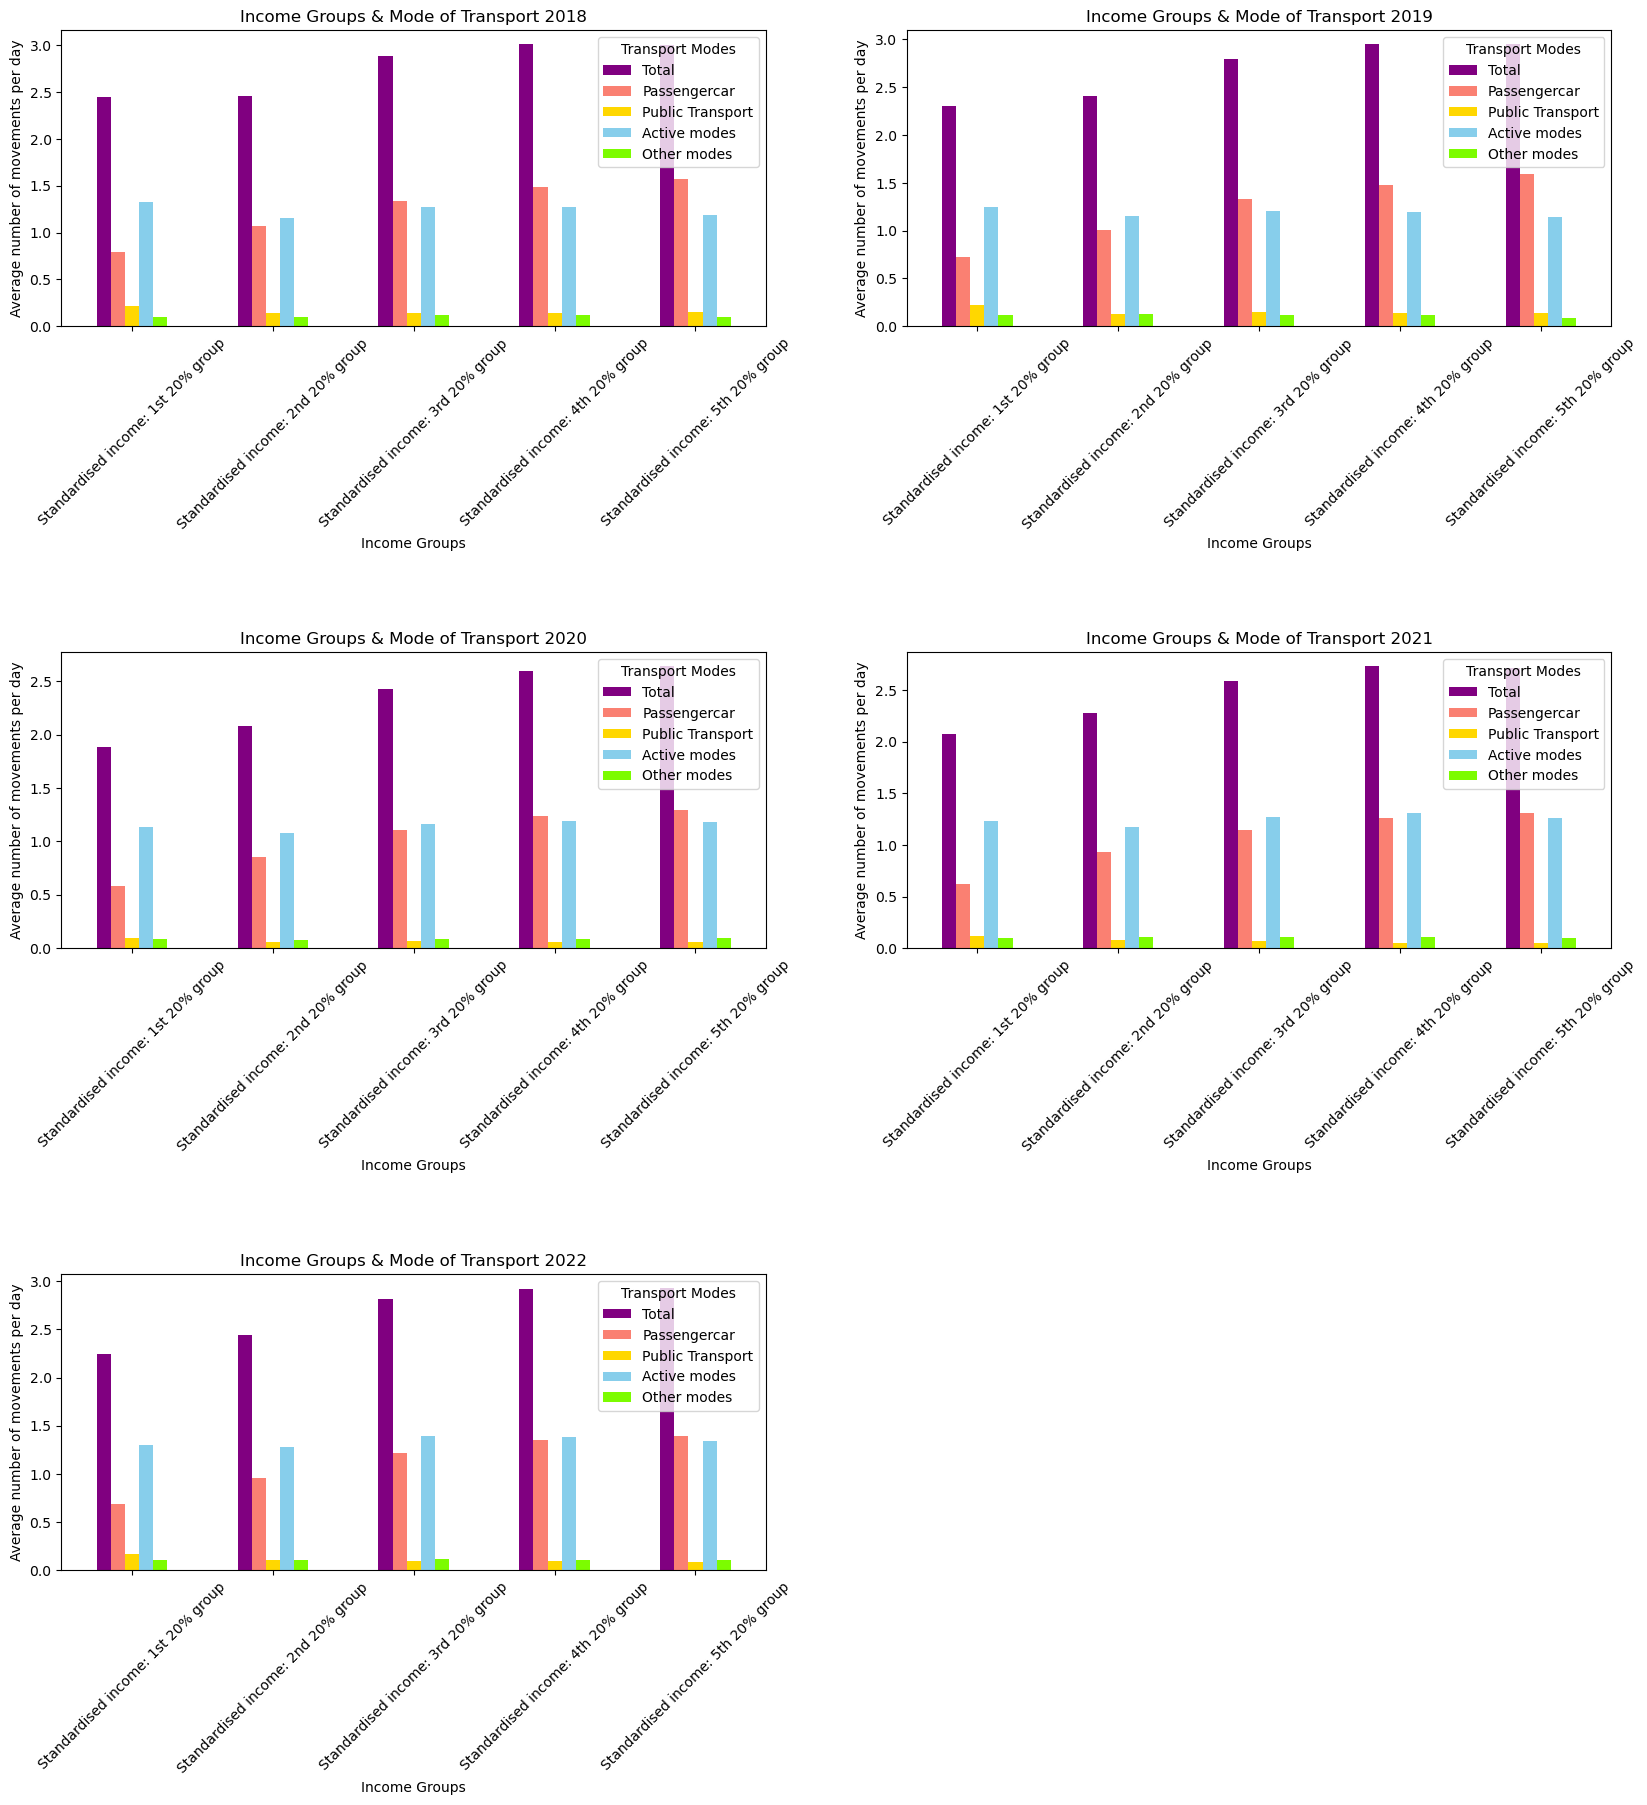

In [66]:
# Filter Income Groups
income_groups = [
    "Standardised income: 1st 20% group",
    "Standardised income: 2nd 20% group",
    "Standardised income: 3rd 20% group",
    "Standardised income: 4th 20% group",
    "Standardised income: 5th 20% group"
]

# Filtered DataFrame for each year
dfs = [transport_2018, transport_2019, transport_2020, transport_2021, transport_2022]

# Changing layout of plots for better readability 
fig, axes = plt.subplots(3, 2, figsize=(20, 20)) # Two rows to show the 5 plots to prevent cluttering
fig.subplots_adjust(hspace=1.1)  
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(dfs):
        df = dfs[i]
        transport_filtered = df.loc[income_groups]
        transport_filtered.plot(kind='bar', stacked=False, color=["purple", "salmon", "gold", "skyblue", "lawngreen"], ax=ax)
        ax.set_title(f"Income Groups & Mode of Transport {2018 + i}")
        ax.set_xlabel("Income Groups")
        ax.set_ylabel("Average number of movements per day")
        ax.legend(title='Transport Modes', loc='upper right')
        ax.tick_params(axis='x', rotation=45)
    else:
        fig.delaxes(ax)  

# Remove the large plots 
plt.close('all')

# Display the combined grid of small plots
display(fig)

**Transport Modes**: The highest income group also has the biggest share in overall transport, as well as the biggest share in car transport. This makes sense as car transport is the most expensive mode out of the four options. simultaneously, it is also true that the lowest income group has the smallest share in car use for the same reasons. The use of active modes differs per income group and doesn't seem to have a connection with the height of the income. Since the 3rd income group seems to have roughly the same use of active transport modes as the 1st income group. 

**COVID impact**: COVID seems to have had a bigger impact on the lower income groups than on the higher income groups. The impact COVID had is not very obvious, as the division over the transport modes for each income group stays roughly the same. But the average number of movements did increase significantly between 2018 and 2020. COVID has had a visible impact on the public transport mode for the 1st income group. This bar (yellow) is significantly smaller in the years 2020 & 2021 than in the 'COVID-free' years. 

**Trends**: A trend that is visible in all the 5 plots, is that the share in overall transport increases as the income inceases. The highest income group has the highest share in transport. This also goes for the share in car transport: if the income increases, the use of car transport increases. If the income increases, the use of public transport decreases. 

### Public transport vs. car ownership vs neither
The following code shows one chart that compares the number of people having a PT Student Card owners, people who have Car and people who have neither during the years. **What is the influence of having PT Student Card comparing owning a car or Neither?**

In [67]:
# Data for 'PT-studentcard: Weekday subscription,' 'Drivers licence; owns own car,' 'No drivers license,' and 'Drivers license; no car' for each year
years = ['2018', '2019', '2020', '2021', '2022']

# Extract the "Total" row for each category
pt_student_card = [transport_2018.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2019.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2020.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2021.loc['PT-studentcard: Weekday subscription', 'Total'],
                   transport_2022.loc['PT-studentcard: Weekday subscription', 'Total']]

owning_car = [transport_2018.loc['Drivers licence; owns own car', 'Total'],
             transport_2019.loc['Drivers licence; owns own car', 'Total'],
             transport_2020.loc['Drivers licence; owns own car', 'Total'],
             transport_2021.loc['Drivers licence; owns own car', 'Total'],
             transport_2022.loc['Drivers licence; owns own car', 'Total']]

# Sum the "No Drivers License" and "Drivers License (No Car)"
no_drivers_license = [transport_2018.loc['No drivers license', 'Total'],
                     transport_2019.loc['No drivers license', 'Total'],
                     transport_2020.loc['No drivers license', 'Total'],
                     transport_2021.loc['No drivers license', 'Total'],
                     transport_2022.loc['No drivers license', 'Total']]

drivers_license_no_car = [transport_2018.loc['Drivers license; no car', 'Total'],
                          transport_2019.loc['Drivers license; no car', 'Total'],
                          transport_2020.loc['Drivers license; no car', 'Total'],
                          transport_2021.loc['Drivers license; no car', 'Total'],
                          transport_2022.loc['Drivers license; no car', 'Total']]

no_drivers_license_and_license_no_car = [no + no_car for no, no_car in zip(no_drivers_license, drivers_license_no_car)]

# Create a DataFrame for the data
data = pd.DataFrame({'Year': years,
                     'PT Student Card': pt_student_card,
                     'Owns a Car': owning_car,
                     'Neither': no_drivers_license_and_license_no_car})


# Create an interactive line chart using Plotly Express with custom colors
fig = px.line(data, x='Year', y=data.columns[1:], labels={'value': 'Total Count'},
              title='PT Student Card vs Car Ownership vs Neither over the Years',
              color_discrete_map={'PT Student Card': 'salmon', 'Owns a Car': 'gold', 'Neither': 'skyblue'})
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.show()

**Transport Mode**: The chart demonstrates that the declining percentages of people having PT student card and people who own a car, from 2018 to 2020 can be attributed to the impact of COVID-19. However, from 2020 to 2022, there is a noticeable rebound in percentages, indicating a gradual recovery towards the pre-COVID-19 levels. The percentage of people having neither despite the fact it was declined, it increased as the other two variables but not as in previous Covid-19 levels.

**COVID-19 Impact**: The initial decline in peoples travels owning PT Student card and people own a car, was primarily due to the COVID-19 pandemic, which led to decreased commuting. From 2020 to 2022, there was a resurgence across all three variables, signaling a return to more typical transportation behaviors.

**Trend**: The data shows a consistent pattern over the years, characterized by two-year periods of declining, followed by two-year periods of increasing. These fluctuations in the numbers can be attributed to the consequences of the COVID-19 pandemic. People tends to travell less during that period but after 2020 the percentage arrived the pre-Covid-19 levels.

### Migration background
The following code shows three plots, made up of the groups with a different Migration background (Netherlands, Western & Non-western) and their Choice of Transport Mode. Each of the plots compare the average number of movements for each of the different years. **Does the choice of transport mode differ for the different migration backgrounds?**

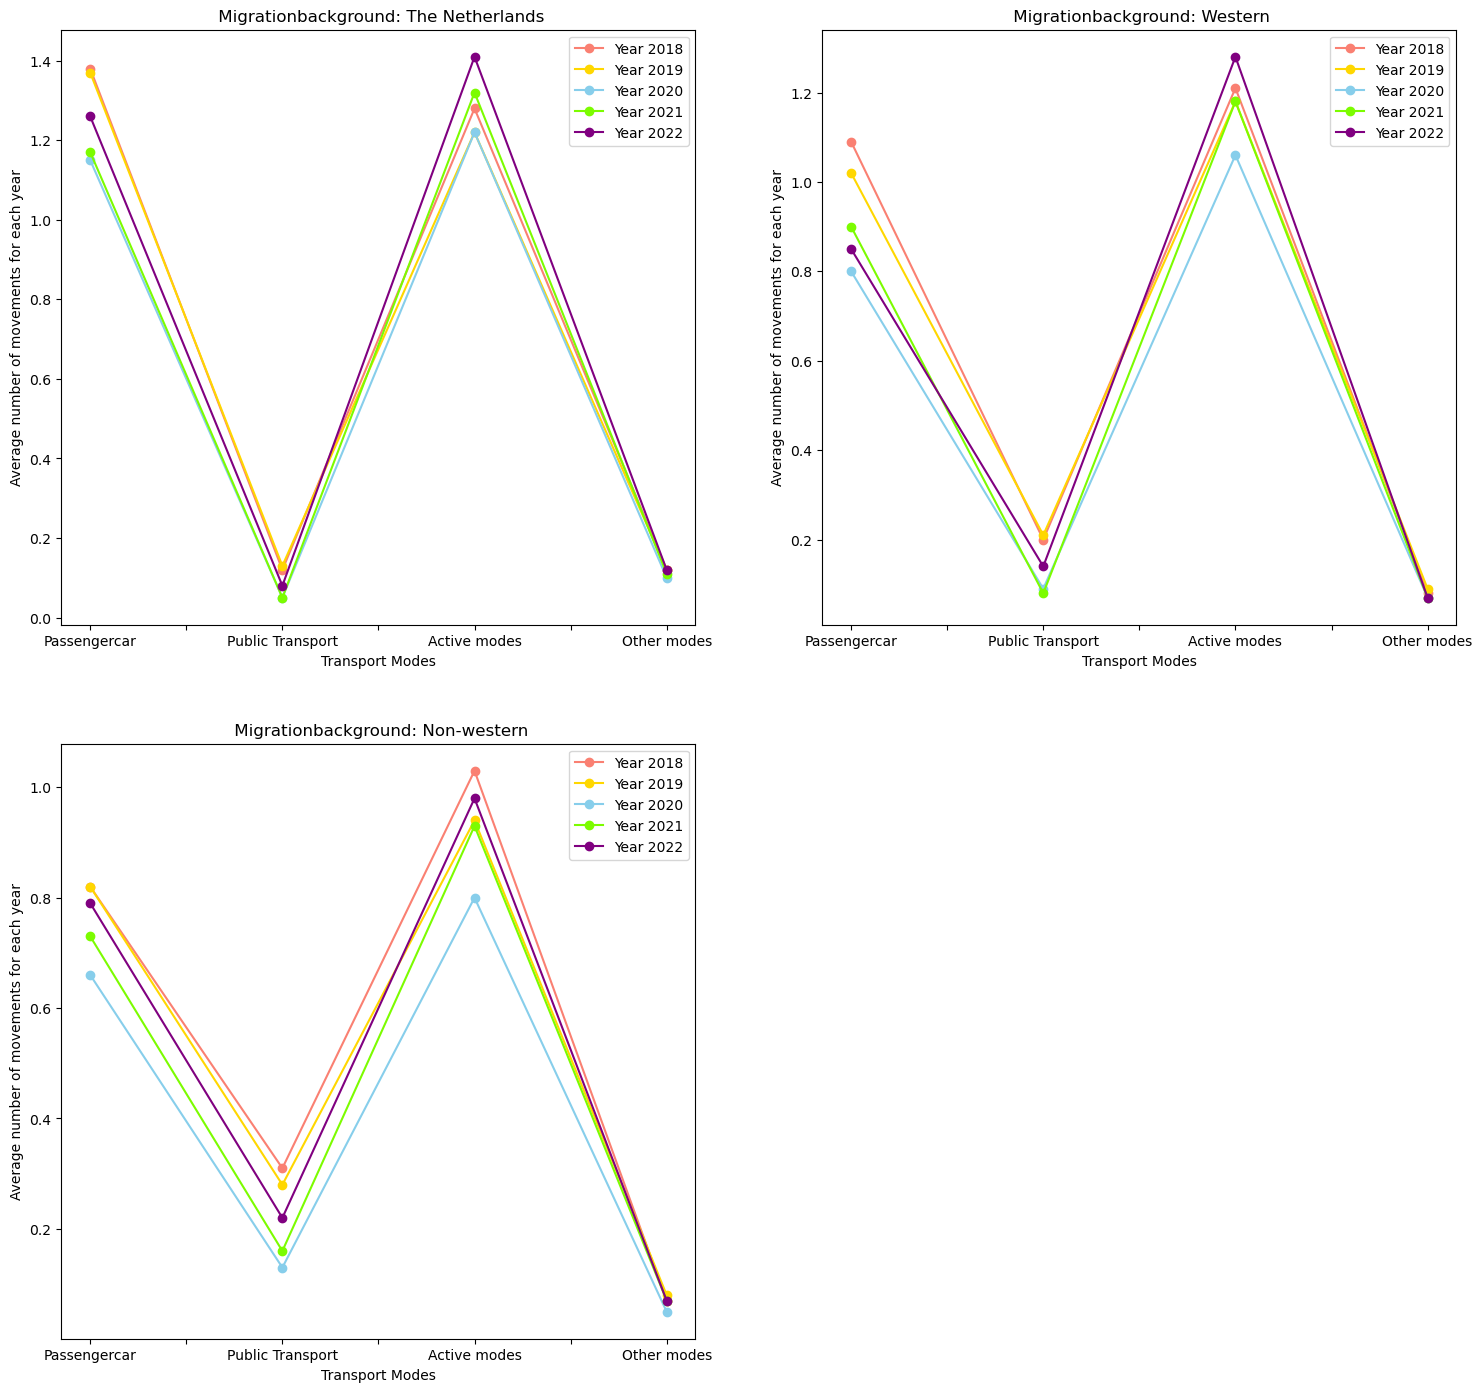

In [68]:
# Filter the three different Migration backgrounds
migration_background = [
    "Migrationbackground: The Netherlands",
    "Migrationbackground: Western",
    "Migrationbackground: Non-western",
]

# Create a grid for the three line plots
fig, axes = plt.subplots(2, 2, figsize=(18, 17))
fig.delaxes(axes[1, 1])  # Remove the fourth empty subplot
colors = ["salmon", "gold", "skyblue", "lawngreen", "purple"]

for i, mbg in enumerate(migration_background):
    ax = axes[i // 2, i % 2]
    ax.set_title(f" {mbg}")
    ax.set_xlabel("Transport Modes")
    ax.set_ylabel("Average number of movements for each year")
    
    for j, df in enumerate(dfs):
        transport_filtered = df.loc[mbg]
        transport_filtered = transport_filtered.T 
        transport_filtered = transport_filtered.drop("Total", errors="ignore")
        transport_filtered.plot(kind='line', color=colors[j], ax=ax, marker='o', label=f"Year {2018 + j}")

    # Create a legend for each subplot
    ax.legend(loc='upper right')

# Hide the individual large plots
plt.close('all')

# Display the combined grid of small plots
display(fig)

**Transport modes**: What becomes visible by looking at the plots is that people with a Dutch migration background have a higher share in overall transport than people with a western or non-western migration background: they have the biggest share in car transport & active modes for all five years. This native group however makes the least use of public transport of the three groups, Non-western people have the biggest share in the public transport mode, in 2018 almost two times bigger than the other two groups.  

**COVID impact**: Another remarkable point that is visible in these linear plots, is the impact COVID has had on the average number of movements. The year 2020(blue line) has the lowest scores on all of the transport modes, for all three of the migration backgrounds. It also shows that the group with a Non-western migration background was hit harder by COVID than the other two groups. Something that confirms COVID to be the cause of this trend, is the fact that the 'post-COVID' year 2022(purple line) scores higher than the COVID-years. 

**Trends**: It seems that the active modes of transport have become more popular than car transport over the last five years in the groups with a Dutch & Western migration background. 

### *Subquestion 3: Is there a significant difference over the years in mode choice?*

To discover of impact of the different years on the mode choice, two plots were created. The first plot shows the transport over the years in absolute numbers. The goal is this is to see the general changes in transport movements over the years. The second plot uses normalised data again. The data is normalised per year by dividing the number of movements per tranport mode by the total number of movements for that year. This essentially gives the probability that someone will choose that transport mode given they travel in that year. The goal of this plot is to visualise the distribution of travel movements over the different transport modes. The two plots combined are used to answer the question.

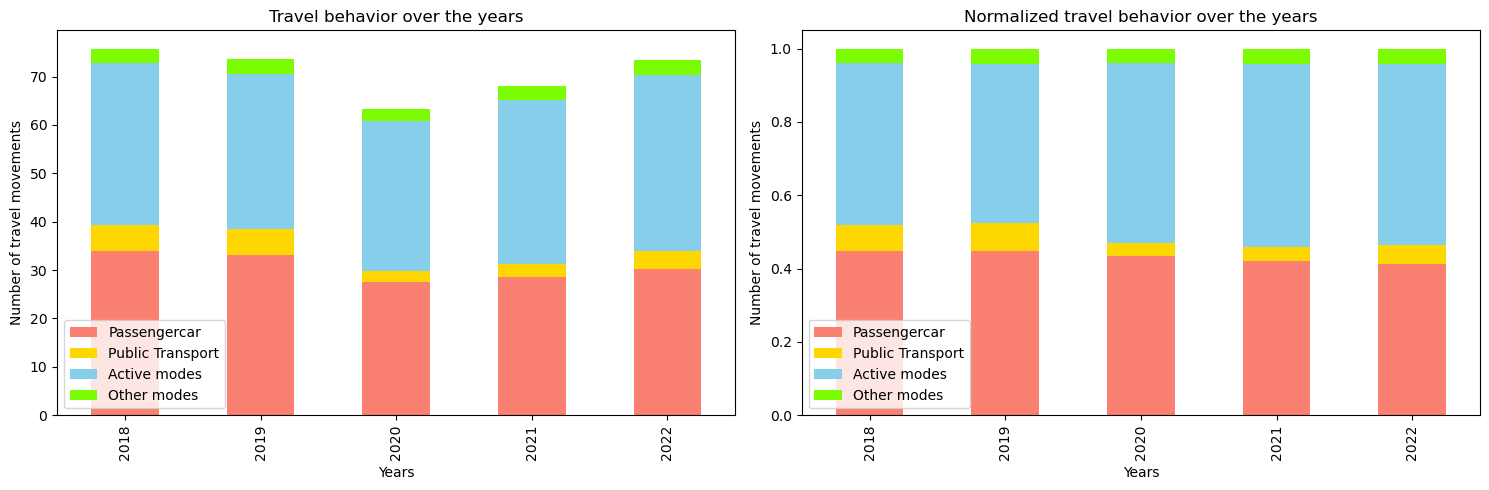

In [69]:
## Creating first plot
# Creating one dataframe containing the total number of transport movements per mode per year
combined_df = pd.DataFrame()
i = 2018
for frame in [transport_2018, transport_2019, transport_2020, transport_2021, transport_2022]: # Iterate over the different years
    data = [sum(frame["Passengercar"]), sum(frame["Public Transport"]), sum(frame["Active modes"]), 
            sum(frame["Other modes"])] # Sum the movements per mode
    combined_df[str(i)] = data # Add to dataframe
    i += 1

index_names = ["Passengercar", "Public Transport", "Active modes", "Other modes"]
combined_df.index = index_names # Give the index the correct names

## Creating second plot
# The see the distribution over the modes, the data needs to be normalised per row
def normal_rows_years(df):
    normal_df = df.div(df.sum(axis = 1), axis = 0) # Normalising each row
    return normal_df

normal_combined_df = normal_rows_years(combined_df.T) # Normalising the combined dataframe

# Plotting both plots next to each other
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create a subplot with two axes

combined_df.T.plot(kind="bar", stacked=True, color=["salmon", "gold", "skyblue", "lawngreen"],
                   ax=axes[0], fontsize=10)  # Plot the first stacked bar plot on the left axis
axes[0].set_title("Travel behavior over the years")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Number of travel movements")

normal_combined_df.plot(kind="bar", stacked=True, color=["salmon", "gold", "skyblue", "lawngreen"],
                        ax=axes[1], fontsize=10)  # Plot the second stacked bar plot on the right axis
axes[1].set_title("Normalized travel behavior over the years")
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Number of travel movements")

plt.tight_layout()
plt.show()

**General impact of time**: In the first plot is a clear decrease in transport movement visible for the year 2020. This was to be expected due to the impact of COVID-19 on society. After 2020, this has started to increase again, but is not yet back to the same height as 2018. This could be explained by more people working (partially) from home and therefore not having to travel as much. 

**Changes in mode distribution**: The focus of the second plot is on the distribution over the different transport modes. Here we again see little difference between 2018 and 2019. However, in 2020 we see a big decrease in the use of public transport, which seems to be completely replaced by the use of active modes. There is also a slight decrease in car movements visible. Furthermore, it becomes visible that the use of public transport only slightly increases after COVID-19. However, instead of the active modes decreasing again, the public transport now comes in the place of passengercar movements. So people seem to be more active since the pandemic.

**Trends**: To conclude, the main difference between the years seems to be caused by COVID-19. The absolute numbers of travel movements decreased and are only slowly increasing back to normal. People seem to prefer active modes over car driving since COVID-19.

### Subquestion 4: *Can the groups obtained through K-means clustering based on personal characteristics effectively reflect distinct transportation mode preferences?*
We start by using the normalized data from the previous subquestion, then we show a correlation plot of the to get a better understanding of the relationship between the different modes based on the personal characteristics data. Next, we determine the number of clusters to make by using the elbow method and calculating the BIC, Silhouette and Davies score for different number of clusters. Based on these results we decide on the number of clusters k, which we then use to make k clusters using the k-means clustering machine learning technique. To answer this subquestion the results are visualized and discussed. 

Based on the goal of subquestion 4 we only do this for the 2018 data. For further research the same method can be applied to the other years.

We start by plotting the correlation between the modes based on the number of movements for every personal characteristic, to obtain a better understanding of the correlation between the modes before clustering. The normalized data used is normalized by dividing each value by the sum of the respective row. So for every personal characteristic, the value for every mode (column) represents the probability that they will choose that mode, like a distribution. Therefore, the sum of all columns for every row equals 1.

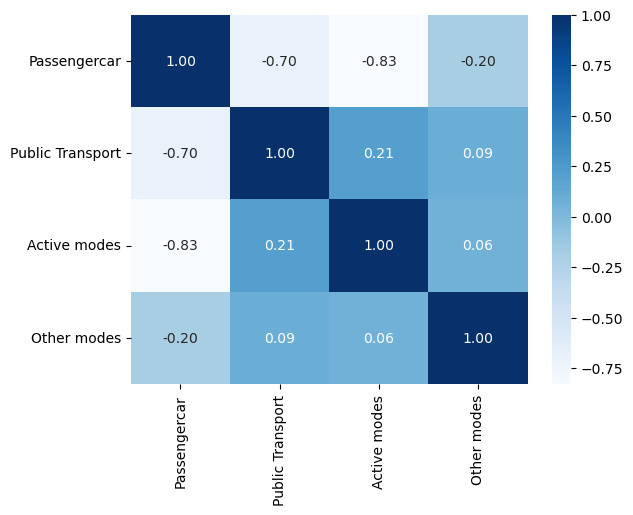

In [70]:
# Correlation plot of mode choices
fig, axes = plt.subplots(1)
corr_2018 = normal_2018.corr()
heatmap_2018 = sns.heatmap(round(corr_2018, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

The heatmap plot reveals several significant correlations among the four transportation modes, shedding light on travel behavior. Notably, there is a robust negative correlation between public transport and passenger car usage. This suggests that individuals who opt for public transport are unlikely to select a car for their subsequent trip. The same trend is observed for active modes, such as biking and walking, which also exhibit a negative correlation with passenger car usage. In contrast, there is a modest positive correlation between active modes and public transport, indicating that those who favor biking or walking are more inclined to use public transportation for their next journey. A slightly negative correlation emerges between other modes and passenger cars. For the remaining combinations, the correlations hover around zero, signifying their independence from one another.

Next, we start the clustering method by determining the number of clusters using the mentioned techniques and scores.

#### K-means clustering

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



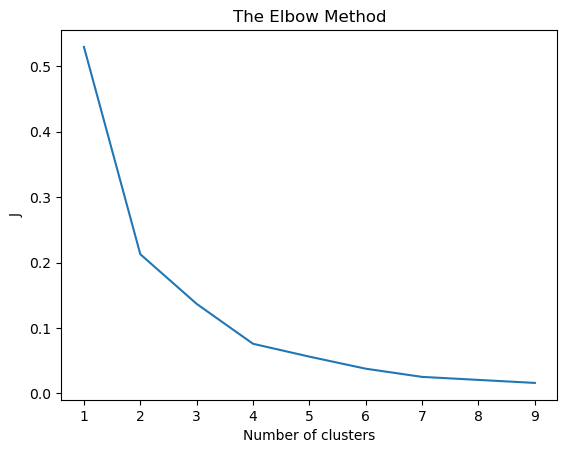

In [71]:
# Elbow method to determine number of clusters
wcss = []
N_max = 10
for i in range(1, N_max):
    kmeans = KMeans(n_clusters=i,random_state=1).fit(normal_2018)
    wcss.append(kmeans.inertia_)
    
plt.figure()
plt.plot(range(1, N_max),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('J')
plt.show()

# The warning that is obtained is researched: whatever the memory leak is, it's tiny.
# For short-running jobs, the script will probably end before the leak gets too bad, and the process will free the memory.

The rule of thumb for the elbow method is to choose the number of clusters where there is a kink in the graph. In this case there is a kink at k = 2, a small kink at k = 3 and large one at k = 4. To be able to make a better choice we also look at some scores to determine the number of clusters.

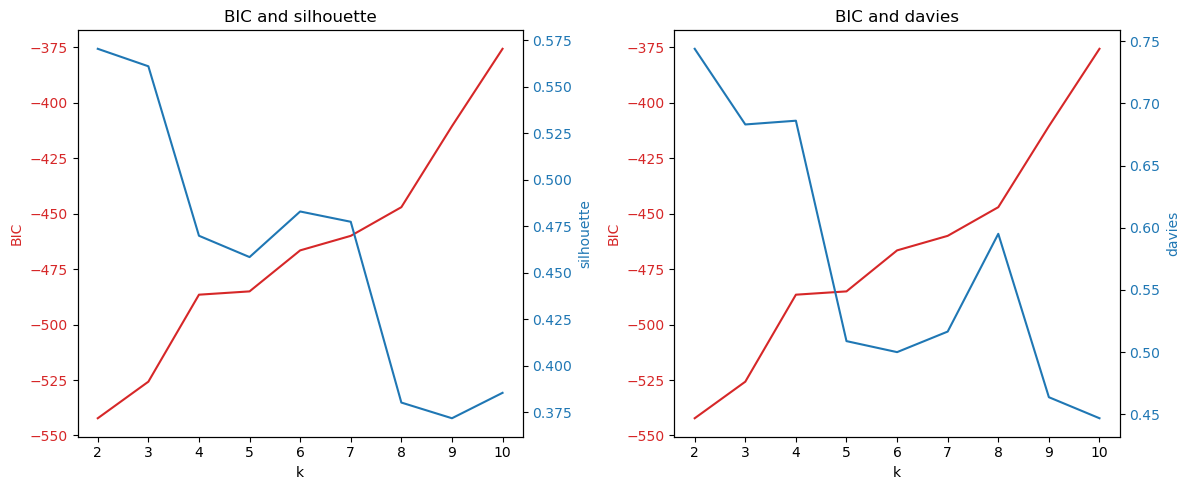

In [72]:
# Calculate different types of scores to decide on number of clusters
def get_km(k, X): # Function to fit KMeans
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    return km

def get_bic(k, X): # Function to calculate BIC
    gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=1)
    gmm.fit(X)
    return gmm.bic(X)

def get_score(k, X): # Function to get other scores (Davies, Silhouette)
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic = get_bic(k, X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    return k, bic, sil, db

# Create dataframe with all scores for different values of k
scores_df = pd.DataFrame([get_score(k, normal_2018) for k in range(2, 11)],
                  columns=['k', 'BIC', 'silhouette','davies'])

def plot_compare(df, y1, y2, x, fig, ax1): # Function that compares scores with scaled axes
    ax1.plot(df[x], df[y1], color='tab:red')
    ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue')
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

def plot_result(df, y1, y2, y3, x): # Function to plot graphs side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with two axes

    plot_compare(df, y1, y2, x, fig, ax1)  # Plot the first graph on the first axis
    plot_compare(df, y1, y3, x, fig, ax2)  # Plot the second graph on the second axis

    plt.tight_layout()
    plt.show()

plot_result(scores_df, 'BIC', 'silhouette', 'davies', 'k')

To interpret the test results it is crucial to know that for the BIC score, the lower is number is better. For the Silhouette score, the higher the number is better and for Davies the lower is better. From the plots it can be seen that k = 3 and k = 4 clusters are the candidates that result in good scores.

Another factor that may be taken into account for determining the number of clusters is the problem definition. Does a specific number of clusters align better with the natural grouping of the data, making it more interpretable in the context of our research question? In our case k = 3 or k = 4 would both be interpretable, since we are looking at three distinct modes (car, public transport and active modes), plus the other mode category that could make k = 4 suitable.

Combining all these results we have decided to choose k = 4 clusters.

Next we apply the 4-means clustering technique in which the data is clustered into 4 clusters, where every personal characteristic will be assigned to one of the clusters. By comparing the clusters correlation with the various modes, we could draw conclusions from which personal characteristics most influence the mode choice of individuals.

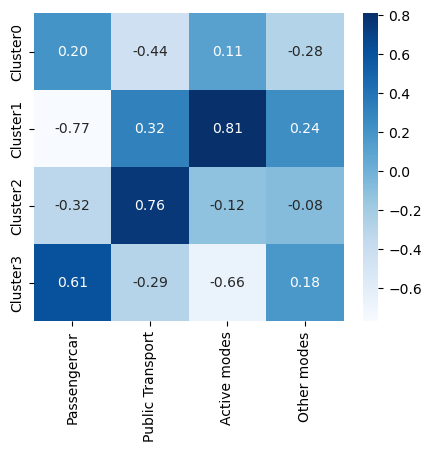

In [73]:
# Apply k-means clustering technique
kmeans = KMeans(n_clusters=4, random_state=1).fit(normal_2018)

# Obtain clusters and add label to data
normal_2018['cluster'] = kmeans.labels_

# Make binary columns in data for each cluster 
normal_2018['Cluster0'] = np.where(normal_2018['cluster'] != 0, 0, 1)
normal_2018['Cluster1'] = np.where(normal_2018['cluster'] != 1, 0, 1)
normal_2018['Cluster2'] = np.where(normal_2018['cluster'] != 2, 0, 1)
normal_2018['Cluster3'] = np.where(normal_2018['cluster'] != 3, 0, 1)

# Make cluster vs. mode correlation plot to see which modes are most present in each cluster
fig, axes = plt.subplots(figsize = (5,4))
correlation_table = normal_2018.corr()
corr2 = correlation_table.drop(correlation_table.index[range(5)])
corr3 = corr2.drop(columns=corr2.columns[4:])
corr_m = sns.heatmap(round(corr3, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

From this heatmap, the following patterns emerge:

- Cluster 0 demonstrates a lack of significant correlation with any of the modes, implying that the characteristics within this cluster are not strongly associated with a particular mode choice.
- Cluster 1 exhibits a strong correlation with active modes, suggesting that individuals with the personal characteristics in this cluster are highly inclined to select an active mode for their travels.
- Cluster 2 displays a strong correlation with public transport, indicating that individuals with the personal characteristics in this cluster are most likely to opt for public transport for their journeys.
- Cluster 3 reveals a substantial correlation with passenger cars, implying that individuals with the personal characteristics in this cluster are strongly inclined to choose a car for their travels.

Next, we will delve deeper into each of these four clusters to further investigate the trends mentioned above.

In [74]:
# Make dataframe for every cluster including personal characteristics corresponding to cluster
cluster0 = normal_2018.loc[normal_2018['cluster'] == 0].drop(columns=normal_2018.columns[4:])
cluster1 = normal_2018.loc[normal_2018['cluster'] == 1].drop(columns=normal_2018.columns[4:])
cluster2 = normal_2018.loc[normal_2018['cluster'] == 2].drop(columns=normal_2018.columns[4:])
cluster3 = normal_2018.loc[normal_2018['cluster'] == 3].drop(columns=normal_2018.columns[4:])

In [75]:
# Make functions for analysis

# Number of characteristics in cluster
def length(cluster):
    output = 'The number of characteristics that are in this cluster is equal to %i from the %i characteristics in the dataset.' \
            % (len(cluster), len(normal_2018))
    print(output)
    
# Average normalized distribution of movements over the four different modes in cluster
def distribution(cluster):
    distribution = {}
    for i in cluster:
        distribution[str(i)] = cluster[i].mean()
    return distribution
    
# Function that returns top two modes with most movements in cluster
def mode_choice(cluster):
    dist = distribution(cluster)
    sort = sorted(((v,k) for k,v in dist.items()))
    mode1 = max(dist, key=dist.get)
    mode2 = sort[-2][1]
    return mode1, mode2

# Print characteristics (index) in cluster
def characteristics(cluster):
    characteristics = cluster.index.values.tolist()
    return characteristics

# Three most influential characteristics for mode choice in cluster
def significant_characteristics(cluster):
    lst = []
    chars = dict(cluster[str(mode_choice(cluster)[0])].nlargest(3)).keys()
    for key in characteristics:
        lst.append(key)
    print('The three characteristics with highest movements for mode "%s" are "%s", "%s" and "%s".' 
          % (str(mode_choice(cluster)[0]), lst[0], lst[1], lst[2])) 

We start by looking at the number of characteristics that are in each cluster.

In [76]:
length(cluster0)
length(cluster1)
length(cluster2)
length(cluster3)

The number of characteristics that are in this cluster is equal to 12 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 4 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 3 from the 27 characteristics in the dataset.
The number of characteristics that are in this cluster is equal to 8 from the 27 characteristics in the dataset.


This distribution results in the following percentages across the clusters:
- The majority, 44%, of the characteristics belong to cluster 0.
- Cluster 3 follows with 30% of the characteristics.
- Cluster 2 accounts for 11% of the characteristics.
- Lastly, 15% of the characteristics fall into cluster 1.

Consequently, cluster 0 contains the largest share of characteristics, followed by cluster 3, cluster 2, and cluster 1. The next step is to identify the most commonly chosen mode within each cluster to assess whether these clusters align with distinct mode preferences.

In [77]:
print(characteristics(cluster0))
print('The mode choice of cluster 0 is mostly %s, in second place is %s.' 
      % (mode_choice(cluster0)[0], mode_choice(cluster0)[1]))

print(characteristics(cluster1))
print('The mode choice of cluster 1 is mostly %s, in second place is %s.' 
      % (mode_choice(cluster1)[0], mode_choice(cluster1)[1]))

print(characteristics(cluster2))
print('The mode choice of cluster 2 is mostly %s, in second place is %s.' 
      % (mode_choice(cluster2)[0], mode_choice(cluster2)[1]))

print(characteristics(cluster3))
print('The mode choice of cluster 3 is mostly %s, in second place is %s.' 
      % (mode_choice(cluster3)[0], mode_choice(cluster3)[1]))

['Age: 65 years or older', 'Migrationbackground: The Netherlands', 'Migrationbackground: Western', 'Standardised income: 2nd 20% group', 'Standardised income: 3rd 20% group', 'Standardised income: 4th 20% group', 'PT-studentcard: None', 'Education level: Low', 'Education level: High', 'Participation: Working 12 to 30 h/w', 'Participation: retired', 'Participation: Other']
The mode choice of cluster 0 is mostly Passengercar, in second place is Active modes.
['Standardised income: 1st 20% group', 'Participation: student', 'Drivers license; no car', 'No drivers license']
The mode choice of cluster 1 is mostly Active modes, in second place is Passengercar.
['Age: 18 to 25 years', 'Migrationbackground: Non-western', 'PT-studentcard: Weekday subscription']
The mode choice of cluster 2 is mostly Active modes, in second place is Passengercar.
['Age: 25 to 35 years', 'Age: 35 to 50 years', 'Age: 50 to 65 years', 'Standardised income: 5th 20% group', 'Education level: middle', 'Participation: Wo

These findings reveal the personal characteristics associated with each cluster and the top two most commonly chosen modes within them:
- Cluster 0: (Passengercar, active modes)
    + Age: 65 years or older
    + Migrationbackground: The Netherlands
    + Migrationbackground: Western
    + Standardised income: 2nd 20% group
    + Standardised income: 3rd 20% group
    + Standardised income: 4th 20% group
    + PT-studentcard: None
    + Education level: Low
    + Education level: High
    + Participation: Working 12 to 30 h/w
    + Participation: retired
    + Participation: Other
- Cluster 1: (Active modes, passengercar)
    + Standardised income: 1st 20% group
    + Participation: student
    + Drivers license; no car
    + No drivers license
- Cluster 2: (Active modes, passengercar)
    + Age: 18 to 25 years
    + Migrationbackground: Non-western
    + PT-studentcard: Weekday subscription
- Cluster 3: (Passengercar, active modes)
    + Age: 25 to 35 years
    + Age: 35 to 50 years
    + Age: 50 to 65 years
    + Standardised income: 5th 20% group
    + Education level: middle
    + Participation: Working 30+ h/w
    + Drivers license; owns own car
    + Drivers license; car in household
 
However, despite these distinct profiles, it is apparent that the clusters do not correspond as expected based on the correlation table. To gain a deeper understanding of the mode choices within each cluster, we will further examine the distribution of mode choices and visualize them in a barplot.

In [78]:
# Make interactive barplot using distribution data of different clusters
data = {
    'Cluster': ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3'],
    'Passengercar': [distribution(cluster0)['Passengercar'], distribution(cluster1)['Passengercar'], 
                     distribution(cluster2)['Passengercar'], distribution(cluster3)['Passengercar']],
    'Public Transport': [distribution(cluster0)['Public Transport'], distribution(cluster1)['Public Transport'], 
                         distribution(cluster2)['Public Transport'], distribution(cluster3)['Public Transport']],
    'Active Modes': [distribution(cluster0)['Active modes'], distribution(cluster1)['Active modes'], 
                     distribution(cluster2)['Active modes'], distribution(cluster3)['Active modes']],
    'Other Modes': [distribution(cluster0)['Other modes'], distribution(cluster1)['Other modes'], 
                    distribution(cluster2)['Other modes'], distribution(cluster3)['Other modes']]
}

df = pd.DataFrame(data)
colors = ["salmon", "gold", "skyblue", "lawngreen"]
df = pd.melt(df, id_vars=['Cluster'], var_name='Mode', value_name='Distribution')

# Create an interactive barplot using Plotly Express
fig = px.bar(df, x='Cluster', y='Distribution', color='Mode',
             color_discrete_sequence=colors,
             title='Movements by Mode in Each Cluster',
             labels={'Cluster': 'Cluster', 'Distribution': 'Distribution'},
             category_orders={'Cluster': ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']}
            )
fig.show()

Analyzing the plot, it becomes evident that passengercar and active modes are dominant across the clusters. Notably, cluster 2 stands out with a substantial portion of public transport users. Therefore, the personal characteristics within cluster 2 likely correspond to a preference for public transport. Cluster 0, on the other hand, displays a considerable divide between passengercar and active modes, making it less indicative of a specific mode choice. Meanwhile, cluster 1 distinctly aligns with personal characteristics that favor active modes, while cluster 3 primarily reflects passengercar usage.

In summary, the identified personal characteristics can be associated with three primary modes, excluding other modes. These clusters offer valuable insights into mode choice patterns based on specific attributes:

- Passengercar:
    + Age: 25 to 35 years
    + Age: 35 to 50 years
    + Age: 50 to 65 years
    + Standardised income: 5th 20% group
    + Education level: middle
    + Participation: Working 30+ h/w
    + Drivers license; owns own car
    + Drivers license; car in household
- Public transport:
    + Age: 18 to 25 years
    + Migrationbackground: Non-western
    + PT-studentcard: Weekday subscription
- Active modes:
    + Standardised income: 1st 20% group
    + Participation: student
    + Drivers license; no car
    + No drivers license

These results can be explained by the following reasoning:
- **Passengercar**: Individuals aged 25 to 65 years with middle-level education and belonging to the 5th 20% income group are more likely to choose passenger cars for daily transportation. Full-time employees working 30+ hours per week, often with driver's licenses and car access, find car ownership practical for their commuting and family needs.
- **Public transport**: Young adults aged 18 to 25 years, especially those with non-western migration backgrounds, prefer public transport due to financial constraints, urban living, and cultural familiarity. Students often rely on public transport for school or university commutes, facilitated by weekday subscriptions.
- **Active mode**: Individuals in the 1st 20% income group, typically students without driver's licenses or cars, favor active modes like walking or biking. Limited financial resources and a focus on local commuting make active modes a practical and economical choice for this group.

# Conlusion
This project focussed on the mobility trends in The Netherlands from the years 2018 - 2022. The goal was to answer the following research question: *“How do personal characteristics influence mode choice behaviour of adult travellers in The Netherlands during the years 2018-2022?”*  The answer to this question will be concluded by using the formulated subquestions.

These plots show several points that should be investigated further to be able to find an answer to the question posed in this report. First of all, there seems to be a difference in the mode distribution between the different age groups, where both young and old people seem to prefer active modes over the car and especially young people also seem to use public transport more than any of the other ages. Furthermore, movement by car seem to often be replaced by active modes for (on average) lower-income groups. Another thing that should be researched in more detail is the effect of having a public transport subscription compared to owning a car or having neither. Finally, the difference between travel movements and mode choice over the years should be investigated. These points and possible explanations for them will be researched in the remainder of this report.

Moving on to the personal characteristics that jumped out of the dataset and needed further elaboration, the second subquestion. The data that was further researched: 
- Income Groups 
- Migration Background 
- Age Groups 
- PT Student Card & Car Ownership 

By visualising this data separately, we were able to draw more specific conclusions of the impact of these characteristics on the mobility trends in The Netherlands.

**Income**: By looking at the choice of transport mode & if this differed between the 5 standardised income groups, the trend that it shows is that - when income increases, so does the use of a car as transportation mode. These plots also showed that, with the increase of income, the use of public transport decreased. This means that the lower income groups have the biggest share of the public transport mode.

**Migration**: The choice of transport mode also differed for the three different migration backgrounds. The native group (The Netherlands) has the biggest share in transport for all five years. Dutch people have the highest car use, as well as use of active modes. However, the group with a Non-western background has the biggest share in the public transport mode, even almost two times bigger than the other groups in 2018. Another remarkable result from these linear graphs is that the active modes of transport have become more popular than car transport over the last five years, most visible in the Dutch & Western migration background groups.

**Age groups**: Over the years, different age groups have exhibited distinct preferences for modes of transportation. Younger individuals (18 to 25 years) often favor public transport and active modes (cycling and walking), while older age groups (35 to 50 years and 50 to 65 years) tend to rely heavily on passenger cars.

**PT student card & car ownership**:

In nearly all the data we visualised there is a clear decrease in transport movement visible for the year 2020. This was to be expected due to the impact of COVID-19 on society. After 2020, there is a general increase again, but most of the data is not yet back to the same height as 2018. For example, COVID seems to have had a bigger impact on the transport behaviour of lower income groups than on the behaviour of higher income groups. The lower income groups make more use of public transport, this mode was visibly impacted due to covid. The impact of COVID is also more visible in the group with a Non-western migration background, since this group also makes most use of the public transportation mode. This is also substantiated with the 2nd plot of the third subquestion: there are only little differences visible between 2018 and 2019. However, in 2020 we see a big decrease in the use of public transport, which seems to be completely replaced by the use of active modes. The main conclusion that is drawn from this project is that the main differences between the years seems to be caused by COVID. The absolute numbers of travel movements decreased and are only slowly increasing back to normal. The groups that had a significant share in the use of public transport were hit the hardest by COVID.

The elaboration of this data helped show that the influence that personal characteristics have on mode choice behaviour can be justified, as well as combined into clusters of personal characteristics that show a mutual pattern regarding their mode choice. This connects with the last subquestion of this project: *"Can the groups obtained through K-means clustering based on personal characteristics effectively reflect distinct transportation mode preferences?"*

Looking at the results obtained in the analysis for this subquestion, the k-means clustering machine learning method can be used to obtain valuable insights into mode choice patterns based on the specific personal characteristics. Comparing the results of the clustering to the results of the analysis done in subquestion 1, 2 and 3 it can be seen that the clustering technique correctly links the personal characteristics to mode choice, indicating that this method effectively reflect distincs transportation mode preferences.

In conclusion, the research demonstrated that personal characteristics significantly influence mode choice behavior, emphasizing the impact of age groups, income, migration background, and the effects of COVID-19 on transportation preferences in the Netherlands from 2018 to 2022. Additionally, the study validated that K-means clustering effectively reflects distinct transportation mode preferences based on specific personal characteristics.


## Limitations and recommendations
**Personal characteristics**
The goal of this research was to be able to predict mode choice based on personal characteristics. It turned out that this was not possible with the available data, because one person can belong to multiple groups. One person could be 22, have a student PT card and a drivers license, placing this person in 3 groups of the data. It is not possible with this data to know which of these categories is the deciding factor on mode choice. To be able to come to specific conclusions on that, a more detailed research should be conducted, where the combination of characteristics per person is known.

**COVID-19**
At the start of this research, the plan was to investigate mode choice purely based on personal characteristics. However, throughout the research it became more and more evident that the influence of COVID-19 could not be ignored. At several point during the research, the influence of COVID-19 on mode choice was clearly visible in the data. It could therefore be interesting to do this research again a couple years from now and compare the results at that time with the years prior to the pandemic, to see if a lasting difference in mode choice is visible.

**Clustering**
The use of clustering was now only tested for 2018. While, the expectation is that this should work the same way for the other years, it is worth investigating whether it would give different results. Especially in 2020 and 2021 a different mode distribution was visible, which could possibly result in different clustering.

# References

[1] NS wil voorstel spitsheffing beperken tot €2,50 per rit (businessinsider.nl)(https://www.businessinsider.nl/ns-wil-voorstel-spitsheffing-beperken-tot-e250-per-rit-veel-verzet-in-tweede-kamer/)

[2] StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl) (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84709NED/table?ts=1696241475558)